# Name: Jackson Dawson

# Group: 9


# Setup


In [1]:
from pyspark import SparkContext
import json

sc = SparkContext.getOrCreate()

# Read JSONL files as text RDDs and parse each line
vg_rdd = sc.textFile("../../data_samples/Video_Games_SAMPLE.jsonl").map(json.loads)
b_rdd = sc.textFile("../../data_samples/Books_SAMPLE.jsonl").map(json.loads)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 19:57:10 WARN Utils: Your hostname, MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.24 instead (on interface en0)
25/12/02 19:57:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 19:57:10 WARN Utils: Your hostname, MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.24 instead (on interface en0)
25/12/02 19:57:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use s

# Analysis

**Question:** How does consumer sentiment differ between video-game products and book products?


## Merge Datasets


In [2]:
# Add category field to each record
vg_rdd = vg_rdd.map(lambda row: {**row, "category": "video_game"})
b_rdd = b_rdd.map(lambda row: {**row, "category": "book"})

In [3]:
# Union the two RDDs
rdd = vg_rdd.union(b_rdd)

In [4]:
# Add text length and title length fields for analysis
rdd = rdd.map(
    lambda row: {
        **row,
        "text_length": len(row["text"]) if row["text"] else 0,
        "title_length": len(row["title"]) if row["title"] else 0,
    }
)

## Side-by-Side Comparison Statistics


In [5]:
import math

# ---- 1. Map each record into (category, value_dict) ----
pair_rdd = rdd.map(
    lambda row: (
        row["category"],
        {
            "count": 1,
            "rating_sum": row["rating"],
            "rating_sq_sum": row["rating"] ** 2,
            "text_sum": row["text_length"],
            "text_sq_sum": row["text_length"] ** 2,
            "title_sum": row["title_length"],
            "helpful_sum": row["helpful_vote"],
            "verified_sum": 1 if row["verified_purchase"] else 0,
            "image_count_sum": len(row["images"]),
        },
    )
)


# ---- 2. Combine values by category ----
def combiner(v):
    return v


def merger(a, b):
    return {
        "count": a["count"] + b["count"],
        "rating_sum": a["rating_sum"] + b["rating_sum"],
        "rating_sq_sum": a["rating_sq_sum"] + b["rating_sq_sum"],
        "text_sum": a["text_sum"] + b["text_sum"],
        "text_sq_sum": a["text_sq_sum"] + b["text_sq_sum"],
        "title_sum": a["title_sum"] + b["title_sum"],
        "helpful_sum": a["helpful_sum"] + b["helpful_sum"],
        "verified_sum": a["verified_sum"] + b["verified_sum"],
        "image_count_sum": a["image_count_sum"] + b["image_count_sum"],
    }


agg = pair_rdd.combineByKey(combiner, merger, merger)


# ---- 3. Compute final statistics ----
def finalize(category, m):
    n = m["count"]
    return {
        "category": category,
        "total_reviews": n,
        "avg_rating": m["rating_sum"] / n,
        "stddev_rating": math.sqrt(
            (m["rating_sq_sum"] / n) - (m["rating_sum"] / n) ** 2
        ),
        "avg_review_length": m["text_sum"] / n,
        "stddev_review_length": math.sqrt(
            (m["text_sq_sum"] / n) - (m["text_sum"] / n) ** 2
        ),
        "avg_title_length": m["title_sum"] / n,
        "avg_helpful_votes": m["helpful_sum"] / n,
        "total_helpful_votes": m["helpful_sum"],
        "verified_purchases": m["verified_sum"],
        "avg_images_per_review": m["image_count_sum"] / n,
    }


final_rdd = agg.map(lambda kv: finalize(kv[0], kv[1]))

# ---- 4. Display results from RDD ----
results = final_rdd.sortBy(lambda row: row["category"]).collect()
for result in results:
    print(f"\nCategory: {result['category']}")
    print(f"  Total Reviews: {result['total_reviews']}")
    print(f"  Avg Rating: {result['avg_rating']:.2f}")
    print(f"  Stddev Rating: {result['stddev_rating']:.2f}")
    print(f"  Avg Review Length: {result['avg_review_length']:.2f}")
    print(f"  Stddev Review Length: {result['stddev_review_length']:.2f}")
    print(f"  Avg Title Length: {result['avg_title_length']:.2f}")
    print(f"  Avg Helpful Votes: {result['avg_helpful_votes']:.2f}")
    print(f"  Total Helpful Votes: {result['total_helpful_votes']}")
    print(f"  Verified Purchases: {result['verified_purchases']}")
    print(f"  Avg Images Per Review: {result['avg_images_per_review']:.2f}")


Category: book
  Total Reviews: 50000
  Avg Rating: 4.41
  Stddev Rating: 1.07
  Avg Review Length: 421.19
  Stddev Review Length: 722.17
  Avg Title Length: 25.29
  Avg Helpful Votes: 1.84
  Total Helpful Votes: 91850
  Verified Purchases: 34746
  Avg Images Per Review: 0.03

Category: video_game
  Total Reviews: 50000
  Avg Rating: 4.05
  Stddev Rating: 1.43
  Avg Review Length: 310.42
  Stddev Review Length: 659.13
  Avg Title Length: 22.89
  Avg Helpful Votes: 1.26
  Total Helpful Votes: 63152
  Verified Purchases: 43058
  Avg Images Per Review: 0.08


In [6]:
# Additional detailed breakdowns

print("\nRATING DISTRIBUTION COMPARISON")
print("=" * 80)
# Map to (category, rating) pairs and count
rating_counts = (
    rdd.map(lambda row: ((row["category"], row["rating"]), 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

# Organize by rating
from collections import defaultdict

rating_by_category = defaultdict(lambda: {"book": 0, "video_game": 0})
for (category, rating), count in rating_counts:
    rating_by_category[rating][category] = count

print(f"{'rating':<10} {'book':<15} {'video_game':<15}")
print("-" * 40)
for rating in sorted(rating_by_category.keys()):
    counts = rating_by_category[rating]
    print(f"{rating:<10} {counts['book']:<15} {counts['video_game']:<15}")


print("\n\nREVIEW LENGTH QUARTILES")
print("=" * 80)
# Group text lengths by category
category_lengths = (
    rdd.map(lambda row: (row["category"], row["text_length"]))
    .groupByKey()
    .mapValues(list)
    .collect()
)

for category, lengths in sorted(category_lengths):
    sorted_lengths = sorted(lengths)
    n = len(sorted_lengths)
    q1_idx = n // 4
    q2_idx = n // 2
    q3_idx = 3 * n // 4

    print(f"\nCategory: {category}")
    print(f"  Min Length: {min(sorted_lengths)}")
    print(f"  25th Percentile: {sorted_lengths[q1_idx]}")
    print(f"  Median: {sorted_lengths[q2_idx]}")
    print(f"  75th Percentile: {sorted_lengths[q3_idx]}")
    print(f"  Max Length: {max(sorted_lengths)}")


print("\n\nHELPFULNESS STATISTICS")
print("=" * 80)
# Calculate helpfulness stats by category
helpful_stats = (
    rdd.map(
        lambda row: (
            row["category"],
            {
                "max_votes": row["helpful_vote"],
                "has_votes": 1 if row["helpful_vote"] > 0 else 0,
            },
        )
    )
    .reduceByKey(
        lambda a, b: {
            "max_votes": max(a["max_votes"], b["max_votes"]),
            "has_votes": a["has_votes"] + b["has_votes"],
        }
    )
    .collect()
)

for category, stats in sorted(helpful_stats):
    print(f"\nCategory: {category}")
    print(f"  Max Helpful Votes: {stats['max_votes']}")
    print(f"  Reviews with Helpful Votes: {stats['has_votes']}")


print("\n\nVERIFIED PURCHASE ANALYSIS")
print("=" * 80)
# Calculate verification stats
verification = (
    rdd.map(
        lambda row: (
            row["category"],
            {"total": 1, "verified": 1 if row["verified_purchase"] else 0},
        )
    )
    .reduceByKey(
        lambda a, b: {
            "total": a["total"] + b["total"],
            "verified": a["verified"] + b["verified"],
        }
    )
    .collect()
)

for category, stats in sorted(verification):
    percentage = (stats["verified"] / stats["total"]) * 100
    print(f"\nCategory: {category}")
    print(f"  Total Reviews: {stats['total']}")
    print(f"  Verified Count: {stats['verified']}")
    print(f"  Verified Percentage: {percentage:.2f}%")


RATING DISTRIBUTION COMPARISON
rating     book            video_game     
----------------------------------------
1.0        2263            6409           
2.0        1802            2721           
3.0        3566            3585           
4.0        7979            6695           
5.0        34390           30590          


REVIEW LENGTH QUARTILES
rating     book            video_game     
----------------------------------------
1.0        2263            6409           
2.0        1802            2721           
3.0        3566            3585           
4.0        7979            6695           
5.0        34390           30590          


REVIEW LENGTH QUARTILES

Category: book
  Min Length: 1
  25th Percentile: 75
  Median: 176
  75th Percentile: 443
  Max Length: 15405

Category: video_game
  Min Length: 0
  25th Percentile: 48
  Median: 129
  75th Percentile: 307
  Max Length: 31302


HELPFULNESS STATISTICS

Category: book
  Min Length: 1
  25th Percentile: 75
  Median: 1

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

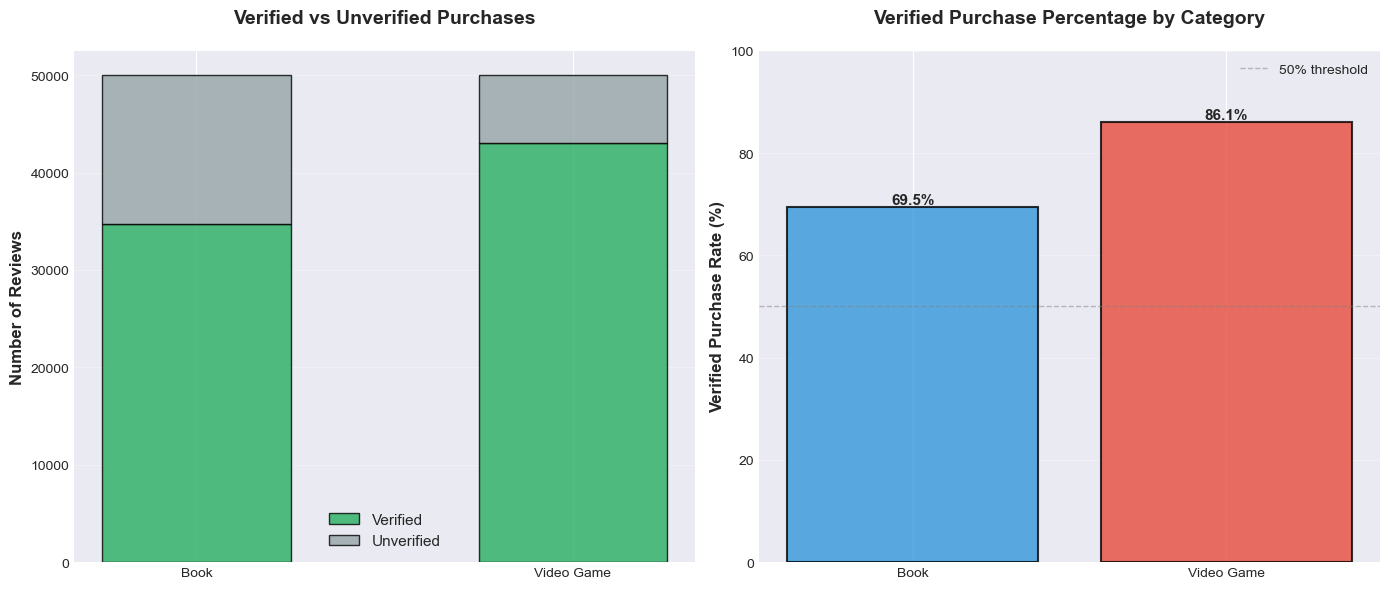

In [8]:
# 4. VERIFIED PURCHASE ANALYSIS
verification = (
    rdd.map(
        lambda row: (
            row["category"],
            {"total": 1, "verified": 1 if row["verified_purchase"] else 0},
        )
    )
    .reduceByKey(
        lambda a, b: {
            "total": a["total"] + b["total"],
            "verified": a["verified"] + b["verified"],
        }
    )
    .collect()
)

# Prepare data
categories = []
total_reviews = []
verified_counts = []
verified_percentages = []

for category, stats in sorted(verification):
    categories.append(category.replace("_", " ").title())
    total_reviews.append(stats["total"])
    verified_counts.append(stats["verified"])
    verified_percentages.append((stats["verified"] / stats["total"]) * 100)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
colors = ["#3498db", "#e74c3c"]

# Left plot: Stacked bar chart (verified vs unverified)
unverified_counts = [
    total - verified for total, verified in zip(total_reviews, verified_counts)
]
x = np.arange(len(categories))
width = 0.5

bars1 = ax1.bar(
    x,
    verified_counts,
    width,
    label="Verified",
    color="#27ae60",
    alpha=0.8,
    edgecolor="black",
)
bars2 = ax1.bar(
    x,
    unverified_counts,
    width,
    bottom=verified_counts,
    label="Unverified",
    color="#95a5a6",
    alpha=0.8,
    edgecolor="black",
)

ax1.set_ylabel("Number of Reviews", fontsize=12, fontweight="bold")
ax1.set_title(
    "Verified vs Unverified Purchases", fontsize=14, fontweight="bold", pad=20
)
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend(fontsize=11)
ax1.grid(axis="y", alpha=0.3)

# Right plot: Percentage comparison
bars3 = ax2.bar(
    categories,
    verified_percentages,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)
ax2.set_ylabel("Verified Purchase Rate (%)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Verified Purchase Percentage by Category", fontsize=14, fontweight="bold", pad=20
)
ax2.set_ylim(0, 100)
ax2.axhline(
    y=50, color="gray", linestyle="--", linewidth=1, alpha=0.5, label="50% threshold"
)
ax2.grid(axis="y", alpha=0.3)
ax2.legend(fontsize=10)

# Add percentage labels
for bar, pct in zip(bars3, verified_percentages):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

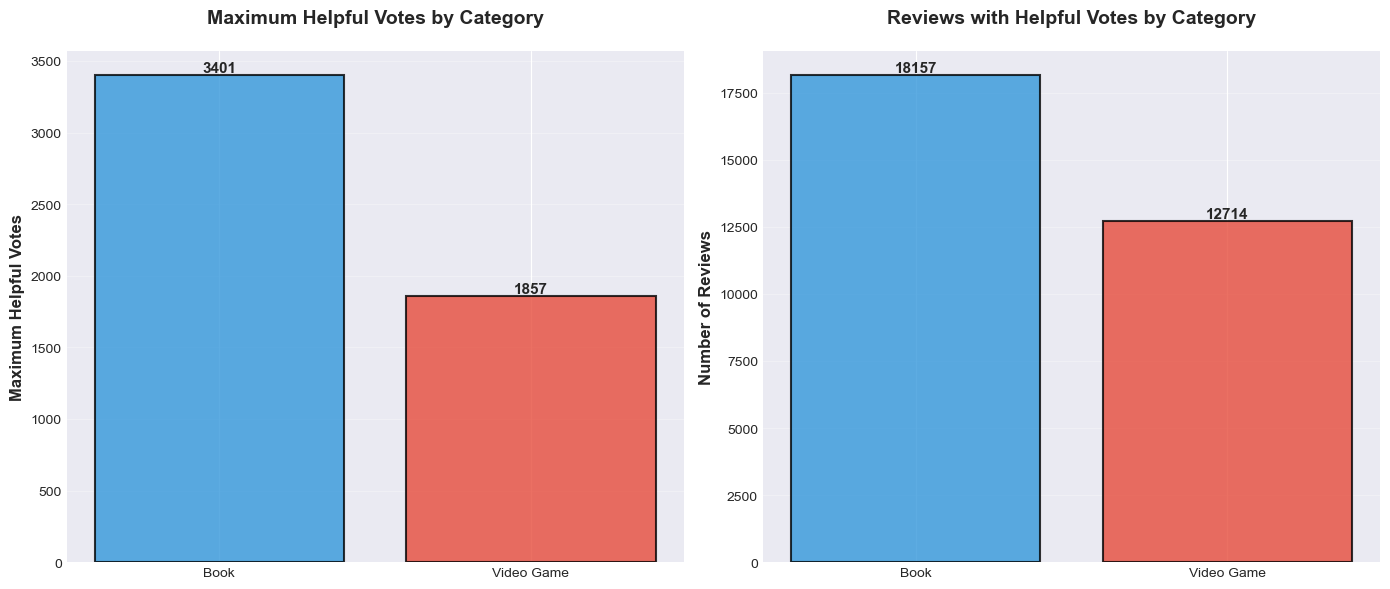

In [9]:
# 3. HELPFULNESS STATISTICS
helpful_stats = (
    rdd.map(
        lambda row: (
            row["category"],
            {
                "max_votes": row["helpful_vote"],
                "has_votes": 1 if row["helpful_vote"] > 0 else 0,
            },
        )
    )
    .reduceByKey(
        lambda a, b: {
            "max_votes": max(a["max_votes"], b["max_votes"]),
            "has_votes": a["has_votes"] + b["has_votes"],
        }
    )
    .collect()
)

# Prepare data
categories = []
max_votes = []
reviews_with_votes = []

for category, stats in sorted(helpful_stats):
    categories.append(category.replace("_", " ").title())
    max_votes.append(stats["max_votes"])
    reviews_with_votes.append(stats["has_votes"])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
colors = ["#3498db", "#e74c3c"]

# Left plot: Max helpful votes
bars1 = ax1.bar(
    categories, max_votes, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5
)
ax1.set_ylabel("Maximum Helpful Votes", fontsize=12, fontweight="bold")
ax1.set_title(
    "Maximum Helpful Votes by Category", fontsize=14, fontweight="bold", pad=20
)
ax1.grid(axis="y", alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Right plot: Reviews with helpful votes
bars2 = ax2.bar(
    categories,
    reviews_with_votes,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)
ax2.set_ylabel("Number of Reviews", fontsize=12, fontweight="bold")
ax2.set_title(
    "Reviews with Helpful Votes by Category", fontsize=14, fontweight="bold", pad=20
)
ax2.grid(axis="y", alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

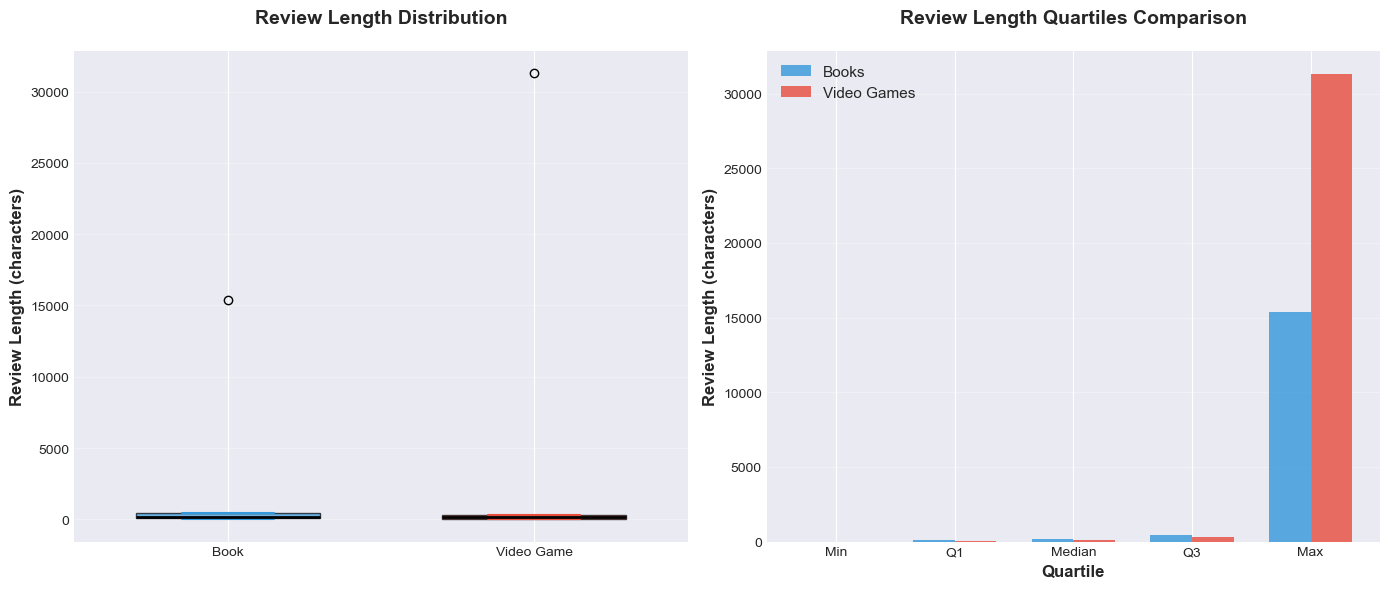

In [10]:
# 2. REVIEW LENGTH QUARTILES
category_lengths = (
    rdd.map(lambda row: (row["category"], row["text_length"]))
    .groupByKey()
    .mapValues(list)
    .collect()
)

# Calculate quartiles for each category
quartile_data = {}
for category, lengths in sorted(category_lengths):
    sorted_lengths = sorted(lengths)
    n = len(sorted_lengths)
    quartile_data[category] = {
        "min": min(sorted_lengths),
        "q1": sorted_lengths[n // 4],
        "median": sorted_lengths[n // 2],
        "q3": sorted_lengths[3 * n // 4],
        "max": max(sorted_lengths),
    }

# Create box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Box plot comparison
categories = list(quartile_data.keys())
colors = ["#3498db", "#e74c3c"]

for idx, category in enumerate(categories):
    q = quartile_data[category]
    bp = ax1.boxplot(
        [[q["min"], q["q1"], q["median"], q["q3"], q["max"]]],
        positions=[idx],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=colors[idx], alpha=0.7),
        medianprops=dict(color="black", linewidth=2),
        whiskerprops=dict(color=colors[idx], linewidth=1.5),
        capprops=dict(color=colors[idx], linewidth=1.5),
    )

ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels([c.replace("_", " ").title() for c in categories])
ax1.set_ylabel("Review Length (characters)", fontsize=12, fontweight="bold")
ax1.set_title("Review Length Distribution", fontsize=14, fontweight="bold", pad=20)
ax1.grid(axis="y", alpha=0.3)

# Right plot: Quartile comparison bars
quartile_labels = ["Min", "Q1", "Median", "Q3", "Max"]
x = np.arange(len(quartile_labels))
width = 0.35

books_vals = [quartile_data["book"][k] for k in ["min", "q1", "median", "q3", "max"]]
games_vals = [
    quartile_data["video_game"][k] for k in ["min", "q1", "median", "q3", "max"]
]

ax2.bar(x - width / 2, books_vals, width, label="Books", color="#3498db", alpha=0.8)
ax2.bar(
    x + width / 2, games_vals, width, label="Video Games", color="#e74c3c", alpha=0.8
)

ax2.set_xlabel("Quartile", fontsize=12, fontweight="bold")
ax2.set_ylabel("Review Length (characters)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Review Length Quartiles Comparison", fontsize=14, fontweight="bold", pad=20
)
ax2.set_xticks(x)
ax2.set_xticklabels(quartile_labels)
ax2.legend(fontsize=11)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

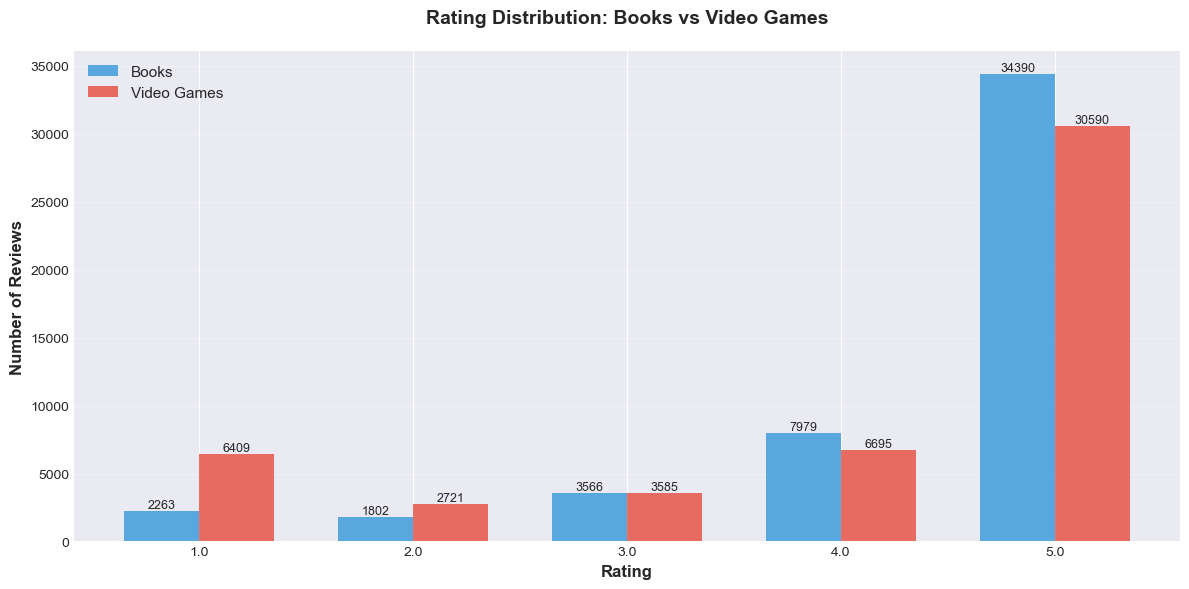

In [11]:
# 1. RATING DISTRIBUTION COMPARISON
rating_counts = (
    rdd.map(lambda row: ((row["category"], row["rating"]), 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

from collections import defaultdict

rating_by_category = defaultdict(lambda: {"book": 0, "video_game": 0})
for (category, rating), count in rating_counts:
    rating_by_category[rating][category] = count

# Prepare data for plotting
ratings = sorted(rating_by_category.keys())
books_counts = [rating_by_category[r]["book"] for r in ratings]
games_counts = [rating_by_category[r]["video_game"] for r in ratings]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(ratings))
width = 0.35

bars1 = ax.bar(
    x - width / 2, books_counts, width, label="Books", color="#3498db", alpha=0.8
)
bars2 = ax.bar(
    x + width / 2, games_counts, width, label="Video Games", color="#e74c3c", alpha=0.8
)

ax.set_xlabel("Rating", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Reviews", fontsize=12, fontweight="bold")
ax.set_title(
    "Rating Distribution: Books vs Video Games", fontsize=14, fontweight="bold", pad=20
)
ax.set_xticks(x)
ax.set_xticklabels(ratings)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()